# **Solar Activity and Market Risk 🌞📉**

*Empirical exploration of the relationship between solar activity and equity market risk.*

---


## Task

This project investigates the **hypothesis** that measures of solar activity (Sunspot Numbers) may be statistically associated with changes in the **risk environment** of the S&P 500 equity market.

Specifically, the underlying assumption is that variations in solar activity could coincide with different market risk regimes, either contemporaneously or with a short temporal lag. The task is therefore **not to assert a causal relationship**, but to empirically test whether such an association can be detected using standard statistical tools, under careful data alignment and without the use of future information.


---

## Background and motivation

Financial risk is a central concept in asset pricing and portfolio management, yet it does **not admit a unique quantitative definition**. Depending on the context, risk may refer to drawdowns, tail losses, uncertainty, or volatility. In empirical finance, however, **volatility remains the most widely used and operational proxy for market risk**.

In this project, market risk is proxied by:

> **Monthly realized volatility**, defined as the within-month standard deviation of daily log-returns.

This choice is motivated by several considerations:

- volatility captures dispersion and uncertainty, rather than average performance;
- it reflects the internal state of the market, not directional bets;
- it can be consistently aggregated to monthly frequency;
- it is a standard benchmark in both academic and applied finance.

Solar activity, by contrast, is a **slow-moving, fully exogenous physical process**, unaffected by market dynamics. Its low frequency naturally motivates a **monthly resolution**, which in turn justifies aggregating market data to the same temporal scale.

---

## Why log-returns are used instead of simple returns

Daily market returns are computed using **logarithmic returns** rather than simple returns, which is standard practice in quantitative finance.

This choice is justified by several mathematical and statistical advantages:

- **Additivity over time**: log-returns are additive across periods, which allows cumulative effects within a month to be treated coherently when estimating volatility.
- **Improved statistical behavior**: log-returns tend to be closer to stationarity and more symmetrically distributed than simple returns, which is desirable for correlation and regression analysis.
- **Scale invariance**: log-returns are independent of the absolute price level, avoiding distortions caused by long-term price growth.
- **Local equivalence**: for small daily price changes, log-returns are numerically very close to simple returns, while preserving the analytical advantages above.

Given that market risk in this project is measured through the **volatility of daily returns aggregated to the monthly level**, log-returns provide a cleaner mathematical framework without altering the economic interpretation of the results.

---

## Methodological approach

The analysis proceeds by constructing a clean monthly dataset combining:

- solar activity measures,
- and realized market risk.

Two temporal alignments are explicitly distinguished:

1. **Retrospective (contemporaneous) analysis**, where solar activity and market risk are aligned within the same month.  
   This setting is explanatory and not predictive.

2. **Predictive (anti-lookahead) analysis**, where solar activity observed in month *M* is used to explain market risk in month *M+1*.  
   This configuration avoids any use of future information.

Statistical analysis includes correlation measures and a simple linear baseline regression, with inference based on heteroskedasticity- and autocorrelation-consistent (HAC / Newey–West) standard errors.

No parameter optimization or trading strategy is pursued.

---

## Scope and limitations

This project does **not** aim to forecast returns or construct an investment strategy.  
Its objective is more modest and precise:

> to test whether solar activity is weakly associated with the market risk regime, either contemporaneously or with a short temporal lag.

Any detected relationship should therefore be interpreted as **structural and contextual**, not as a direct or exploitable predictive signal.

---

## Disclaimer

This analysis is conducted for research and educational purposes only.  
It does not constitute investment advice or a recommendation to buy or sell any financial asset.


## Data and Sources

This project combines two independent datasets with different temporal resolutions:

1) **Equity market data (S&P 500 index)**  
Daily price data for the S&P 500 index are obtained programmatically using the
<a href="https://pypi.org/project/yfinance/" target="_blank">yfinance</a> Python package,
which provides a convenient interface to historical data from
<a href="https://finance.yahoo.com/" target="_blank">Yahoo Finance</a>.
The data include daily open, high, low, close, adjusted close prices, and trading volume.

2) **Solar activity data (Sunspot Number)**  
Monthly Sunspot Number data are obtained from the
<a href="https://www.sidc.be/silso/" target="_blank">SILSO / SIDC</a>
(Sunspot Index and Long-term Solar Observations) service maintained by the
Royal Observatory of Belgium.  
These data represent monthly observations of solar activity and are treated as
being available only at the **end of each month**, which is explicitly accounted
for in the empirical analysis to avoid look-ahead bias.

Solar data are observed at monthly frequency, while market prices are observed daily. No transformation or aggregation is applied at this stage; all alignment and feature construction are described in the subsequent section.


In [1]:
# Import required libraries
from solar_market_risk import *


In [2]:
# Example: S&P 500 index (^GSPC) or SPY ETF
df_market = download_market_data_yahoo(ticker="^GSPC", start="2005-01-01")

# === Yahoo Finance market data ===
df_market.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5275 entries, 2005-01-03 to 2025-12-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       5275 non-null   float64
 1   high       5275 non-null   float64
 2   low        5275 non-null   float64
 3   close      5275 non-null   float64
 4   adj_close  5275 non-null   float64
 5   volume     5275 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 288.5 KB


In [3]:
# Fetch monthly sunspot data (month-end timestamps)
df_sunspot = fetch_monthly_sunspot_number()
# === Monthly Sunspot Number Data ===
df_sunspot.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3323 entries, 1749-01-31 to 2025-11-30
Freq: ME
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   decimal_year    3323 non-null   float64
 1   sunspot_number  3323 non-null   float64
 2   sunspot_std     3323 non-null   float64
 3   n_obs           3323 non-null   int32  
 4   is_definitive   3323 non-null   int8   
dtypes: float64(3), int32(1), int8(1)
memory usage: 120.1 KB


## Data Preparation and Monthly Aggregation

Given the different frequencies of the datasets, all analysis is conducted at a **monthly resolution**.

- **Data quality checks**:  
  Although both datasets are obtained from well-established public sources and are largely clean by construction, basic data validation is performed prior to any transformation. This includes verifying the absence of missing values, checking data types, and confirming that date indices and price fields are properly formatted. These checks ensure that subsequent statistical results are not affected by avoidable data issues.

- **Market risk construction**:  
  Daily S&P 500 prices are converted into **daily log-returns**, and market risk is measured as **monthly realized volatility**, defined as the within-month standard deviation of daily log-returns.

- **Solar activity alignment**:  
  Monthly solar activity is aligned to market data in two distinct ways:
  1. **Retrospective (contemporaneous)**: solar activity and market risk are aligned within the same calendar month.
  2. **Predictive (anti-lookahead)**: solar activity observed in month *M* is aligned with market risk in month *M+1*, ensuring no use of future information.

This aggregation avoids artificial duplication of monthly solar values at the daily level and ensures a clean, statistically coherent monthly dataset for subsequent analysis.


In [4]:
# ============================================================
# 1) Retrospective / contemporaneous analysis (NO prediction)
#    Solar activity and market risk are aligned within the same month
# ============================================================

df_monthly_retro = build_monthly_risk_solar_dataframe(
    df_sunspot=df_sunspot,
    df_market=df_market,
    look_ahead=True
)


# ============================================================
# 2) Predictive / anti-lookahead setup (MODEL INPUT)
#    Solar activity from month M is used to explain risk in month M+1
# ============================================================

df_monthly_predictive = build_monthly_risk_solar_dataframe(
    df_sunspot=df_sunspot,
    df_market=df_market,
    look_ahead=False
)


## Correlation Analysis

Before estimating any regression model, we begin with a **model-free correlation analysis** between solar activity and market risk.

The analysis is conducted **twice**, using two different temporal alignments:

- **Retrospective (contemporaneous)**: solar activity and monthly market risk are aligned within the same calendar month.
- **Predictive (anti-lookahead)**: solar activity observed in month *M* is correlated with market risk in month *M+1*.

For each case, both **Pearson correlation** (linear association) and **Spearman correlation** (rank-based, monotonic association) are computed.

Correlation analysis serves as a preliminary diagnostic: while correlation does not imply causality or predictability, it provides an initial assessment of whether any linear or monotonic relationship is detectable in the data. In particular, a near-zero correlation would already suggest that any potential effect is likely to be weak and dominated by other market dynamics.


In [5]:
# ============================================================
# 1) Retrospective / contemporaneous correlation analysis
# ============================================================

print_correlation_analysis(df_monthly_retro)


Correlation analysis:
Pearson correlation  : -0.152726 (p-value = 0.0154)
Spearman correlation : -0.130082 (p-value = 0.0395)


In [6]:
# ============================================================
# 2) Predictive / anti-lookahead correlation analysis
# ============================================================

print_correlation_analysis(df_monthly_predictive)

Correlation analysis:
Pearson correlation  : -0.161187 (p-value = 0.0104)
Spearman correlation : -0.131403 (p-value = 0.0371)


## Interpretation of Correlation Results

The correlation analysis reveals a **weak but statistically detectable negative association** between solar activity and market risk, both in the retrospective and predictive settings.

### Retrospective (contemporaneous) alignment

- **Pearson correlation**: −0.153 (p-value = 0.015)  
- **Spearman correlation**: −0.130 (p-value = 0.040)

These results indicate that, within the same month, higher levels of solar activity tend to be associated with **lower realized market risk**. The fact that both Pearson and Spearman correlations are negative and statistically significant suggests that the relationship is not driven by a small number of outliers and is robust to departures from strict linearity.

This contemporaneous association should be interpreted as **explanatory**, not predictive: it indicates that solar activity and the market risk environment tend to co-move weakly within the same time window.

---

### Predictive (anti-lookahead) alignment

- **Pearson correlation**: −0.161 (p-value = 0.010)  
- **Spearman correlation**: −0.131 (p-value = 0.037)

When solar activity observed in month *M* is aligned with market risk in month *M+1*, the results remain remarkably similar in both sign and magnitude. The persistence of a negative correlation under this strict anti-lookahead setup indicates that the observed relationship is **not an artifact of contemporaneous alignment**.

Importantly, this predictive correlation does not imply strong forecasting power. Rather, it suggests that periods of higher solar activity are **weakly associated with subsequent months characterized by lower market volatility**, consistent with a gradual shift in the market risk regime rather than an immediate or exploitable signal.

---

### Overall interpretation

Several points are worth emphasizing:

- The **magnitude of the correlations is small** (around −0.13 to −0.16), which is expected when relating a slow, exogenous physical variable to a highly complex and noisy financial system.
- The **consistency of the sign** across Pearson and Spearman measures, and across both temporal alignments, supports the existence of a weak structural association.
- These results do **not** suggest a direct causal mechanism or a trading signal, but rather point to solar activity as a potential **contextual or regime-related factor**.

Taken together, the correlation analysis provides initial empirical evidence that solar activity is weakly but systematically related to the market risk environment. This motivates further analysis using regression-based approaches, while maintaining a cautious interpretation of economic significance.


## Baseline Regression Analysis (OLS with HAC / Newey–West Inference)

To complement the correlation results, we estimate a simple baseline regression linking monthly market risk to solar activity:

$y_t = \alpha + \beta x_t + \varepsilon_t$

where:

- $y_t$ is **monthly market risk** (monthly realized volatility),
- $x_t$ is **solar activity** (aligned either retrospectively or predictively),
- $\varepsilon_t$ is an error term capturing all other market dynamics.

The coefficient $\beta$ measures the average linear change in monthly risk associated with a one-unit change in solar activity.

---

### Why classical OLS standard errors are not sufficient

Although the OLS estimator for $(\alpha, \beta)$ is appropriate as a baseline, **classical OLS inference** relies on strong assumptions about the error process, notably that the residuals are approximately:

- homoskedastic (constant variance), and
- uncorrelated over time.

These assumptions are typically violated in monthly risk series. Volatility is well known to exhibit **persistence and clustering**, implying that residuals may be serially correlated. In addition, financial time series often exhibit time-varying variance (heteroskedasticity). When these conditions hold, classical OLS standard errors can be **systematically underestimated**, inflating $t$-statistics and producing misleading $p$-values.

---

### HAC / Newey–West standard errors (the key step)

To obtain valid inference under heteroskedasticity and autocorrelation, we use **HAC (heteroskedasticity and autocorrelation consistent) standard errors**, commonly referred to as **Newey–West**.

In the implementation, this corresponds to:

`ols_hac = ols.get_robustcov_results(cov_type="HAC", maxlags=hac_lags)`

Conceptually, the Newey–West estimator replaces the classical covariance matrix with an estimate that remains consistent even when:

- $\mathrm{Var}(\varepsilon_t)$ changes over time (heteroskedasticity), and
- $\mathrm{Cov}(\varepsilon_t, \varepsilon_{t-k}) \neq 0$ for $k>0$ (autocorrelation).

Formally, the HAC covariance of the OLS coefficients can be written as:

$\mathrm{Var}(\hat{\beta}) \approx (X'X)^{-1}\left(\sum_{k=-L}^{L} w_k \, \Gamma_k \right)(X'X)^{-1}$

where:
- $L$ is the maximum lag (`hac_lags`),
- $\Gamma_k$ are lag-$k$ autocovariance terms of the score/residual process,
- $w_k$ are weights (typically Bartlett weights) that downweight higher lags.

This adjustment does **not** change the point estimates $(\hat{\alpha}, \hat{\beta})$, but it can substantially change the **standard errors and significance tests**, which is crucial for time-series credibility.

---

### Choice of `hac_lags`

Because the data are monthly, we set `hac_lags = 12`, which corresponds to roughly **one year of autocorrelation structure**. This is a defensible and interpretable choice for monthly macro/financial risk measures and avoids overly conservative settings that can inflate standard errors unnecessarily.

---

### Interpretation guideline

The regression is used as a **baseline diagnostic**, not as a predictive model. The primary goal is to verify whether the sign and magnitude of $\hat{\beta}$ are consistent with the correlation analysis, while ensuring that statistical inference remains valid under realistic time-series conditions through HAC/Newey–West standard errors.


=== OLS (classical SE) ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     6.669
Date:                Fri, 19 Dec 2025   Prob (F-statistic):             0.0104
Time:                        00:41:55   Log-Likelihood:                 902.06
No. Observations:                 252   AIC:                            -1800.
Df Residuals:                     250   BIC:                            -1793.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0109    

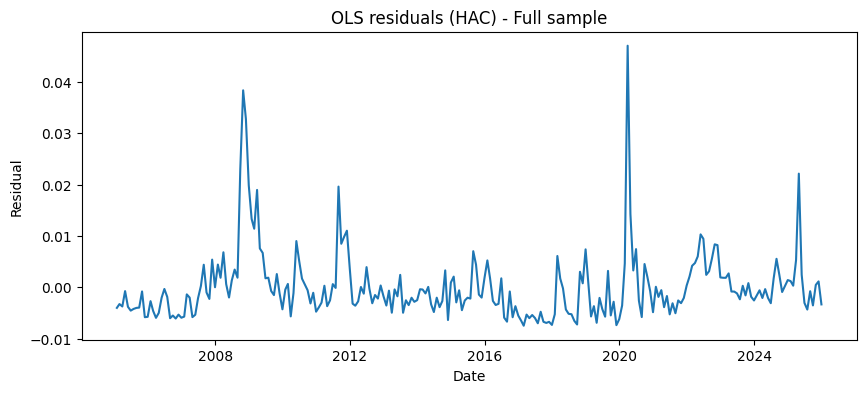


Key results (HAC):
beta_solar = -2.25978e-05
t-stat     = -1.285
p-value    = 0.2
R^2 (OLS)  = 0.0259811


In [7]:
out_full = run_ols_baseline_monthly_risk_vs_solar(
    df_monthly_predictive,
    hac_lags=12,
    plot_residuals=True,
    titulo_residuos="OLS residuals (HAC) - Full sample"
)


## Interpretation of Regression Results (Baseline)

The baseline regression provides a useful complement to the correlation analysis, while illustrating the importance of correct inference in time-series settings.

Under **classical OLS standard errors**, the estimated coefficient on solar activity is negative and statistically significant:

- $\hat{\beta} = -2.26 \times 10^{-5}$
- $t$-statistic ≈ −2.58  
- $p$-value ≈ 0.01  
- $R^2 \approx 0.026$

At face value, this would suggest a negative linear association between solar activity and monthly market risk. However, this inference relies on strong assumptions about the regression residuals.

Once **HAC / Newey–West standard errors** (12 monthly lags) are applied, the point estimate remains unchanged, but statistical significance is reduced:

- $t$-statistic ≈ −1.29  
- $p$-value ≈ 0.20  

This indicates that the apparent significance under classical OLS is sensitive to serial correlation and heteroskedasticity, which are well-known features of volatility-related time series.

At this stage, the regression results should be viewed as **exploratory and diagnostic**. They confirm the direction and order of magnitude suggested by the correlation analysis, but do not yet provide strong evidence of a robust linear effect. A more complete interpretation requires examining the **stability of the relationship over time**, which is addressed in the next section.


In [8]:
df_stability = ols_stability_table_three_periods(
    df_monthly_predictive,
    hac_lags=12
)

df_stability


,n_obs,start,end,beta_solar,t_solar,p_solar,r2
period,,,,,,,
P1,84,2005-01-31,2011-12-31,-0.000054,-0.722558,0.472007,0.033074
P2,84,2012-01-31,2018-12-31,0.000002,0.129744,0.897087,0.000411
P3,84,2019-01-31,2025-12-31,-0.000015,-0.944038,0.347924,0.016632


## Stability Analysis Across Subperiods

To assess whether the baseline relationship is stable over time, the full sample is split into **three equal subperiods** and the same OLS regression with HAC inference is estimated separately in each block.

The results show substantial variation across subperiods:

- **P1 (2005–2011)**: the estimated coefficient is negative, but not statistically significant.
- **P2 (2012–2018)**: the coefficient is effectively zero, indicating no detectable association during this period.
- **P3 (2019–2025)**: the coefficient returns to a negative sign, but remains statistically insignificant.

Across all three subperiods:
- none of the estimates are statistically significant under HAC standard errors;
- the explanatory power remains very low ($R^2$ close to zero);
- the sign of the coefficient is not fully stable over time.

These results suggest that the relationship between solar activity and market risk, while present as a weak association in the full sample, **is not uniform across time**. This lack of stability motivates a cautious interpretation and reinforces the need to consider the results as **contextual rather than structural**, an issue discussed more fully in the final section.


## Final Conclusions and Practical Implications

This project set out to evaluate the **hypothesis** that solar activity may contain useful information about the **risk environment** of the S&P 500 equity market, with the ultimate goal of assessing whether such information could reasonably support **investment-related decisions**.

---

### Summary of empirical findings

The analysis yields a coherent and internally consistent set of results:

- **Correlation analysis** reveals a weak but statistically detectable **negative association** between solar activity and market risk, both contemporaneously and with a one-month lag. Higher solar activity tends to coincide with, or slightly precede, periods of lower realized volatility.
- **Baseline regression analysis** confirms the direction and order of magnitude of this association, but shows that statistical significance is **not robust** once heteroskedasticity and autocorrelation are properly accounted for using HAC / Newey–West inference.
- **Stability analysis across subperiods** indicates that the relationship is **not uniform over time**. The estimated effect varies in magnitude and even becomes indistinguishable from zero in some periods, with no subperiod exhibiting statistically significant results under robust inference.

Taken together, these findings point to a relationship that is **weak, unstable, and dominated by the internal dynamics of market risk**.

---

### Interpretation in the context of the challenge

From a scientific perspective, the results suggest that solar activity may act as a **slow-moving contextual variable**, weakly associated with the market’s risk regime. However, this association:

- explains only a very small fraction of the variation in market risk,
- lacks temporal stability,
- and does not survive stringent statistical inference as a strong linear effect.

From an **investment and capital allocation standpoint**, these characteristics are decisive.

---

### Recommendation regarding investment use

Based on the evidence presented in this analysis:

- **Solar activity data should not be used as a standalone signal** for investment decisions or risk timing.
- The detected associations are **too weak and unstable** to support systematic trading or allocation strategies.
- Any attempt to directly exploit this relationship would likely be overwhelmed by noise, regime changes, and more dominant market forces.

At most, solar activity could be considered as a **secondary, contextual input** within a broader analytical framework, for example as a qualitative indicator of background conditions rather than as an actionable quantitative signal.

---

### Final assessment

In conclusion, while the analysis provides interesting empirical evidence of a weak association between solar activity and market risk, it does **not** support the use of solar data as a reliable or economically meaningful driver for investment decisions. The results are best interpreted as an illustration of how exogenous physical variables may correlate with financial market regimes, rather than as a foundation for capital deployment.

This conclusion aligns with the broader empirical finance literature: **detectable statistical relationships do not automatically translate into usable investment signals**, especially in complex, adaptive systems such as financial markets.


## Results and interpretation

The empirical results do not provide evidence that solar activity, as measured by the monthly Sunspot Number, contains incremental predictive information about daily S&P 500 returns.

Across all specifications, the estimated coefficient on the lagged sunspot variable is statistically indistinguishable from zero. This conclusion holds both under classical OLS standard errors and under heteroskedasticity and autocorrelation robust (Newey–West) standard errors. The magnitude of the estimated effect is economically negligible, and the explanatory power of the model, as measured by the R-squared, is effectively zero.

These findings are consistent with the well-known difficulty of predicting daily equity returns and suggest that, at this frequency, any potential relationship between solar activity and market returns is either extremely weak or dominated by noise.

Importantly, the absence of statistical significance is robust to conservative timing assumptions designed to eliminate look-ahead bias. The result therefore reflects a genuine lack of predictive content rather than a modeling or data-alignment artifact.


## Limitations

Several limitations of the present analysis should be acknowledged.

First, the empirical design focuses on **daily returns**, which are known to be highly noisy and difficult to predict. It is possible that any behavioral effects associated with solar activity, if they exist, may operate at lower frequencies and be more difficult to detect at the daily level.

Second, the analysis relies on a **single proxy for solar activity**. While the Sunspot Number is a standard and widely used indicator, it may not fully capture the aspects of solar or geomagnetic activity hypothesized to influence human mood or risk preferences.

Finally, the results are conditional on a deliberately simple and transparent modeling framework. While this is appropriate for a baseline empirical test, more complex nonlinear or regime-dependent effects are not explored here.


## Investment conclusion

Based strictly on the empirical evidence presented in this analysis, we would **not allocate capital** to a trading strategy based on solar activity signals.

The estimated relationship between sunspot activity and daily S&P 500 returns is neither statistically significant nor economically meaningful. Moreover, the lack of robustness across standard inference frameworks and the near-zero explanatory power indicate that the signal does not provide a reliable source of predictability.

From an investment perspective, incorporating such a signal would add complexity without improving expected performance and would not meet the standards required for systematic capital allocation at Wise Capital.

While the hypothesis is intellectually interesting and grounded in behavioral finance considerations, the data do not support its practical implementation as an investable signal in this context.
